第6章

由Cam Davidson-Pilon创建的原始内容

由Max Margenot（@clean_utensils）和Thomas Wiecki（@twiecki）在Quantopian（@quantopian）上移植到Python 3和PyMC3

由Kurisu Chan（@miemiekurisu）最后移植到PyMC

---

这一章节着重讨论贝叶斯方法中最有争议和讨论最多的部分：如何选择适当的先验分布。我们还展示了随着数据集增加，先验分布对结果的影响如何变化，以及先验与线性回归中的惩罚之间的有趣关系。

##明确我们的优先次序

直到现在，我们大部分时间忽视了我们的先验选择。这是不幸的，因为我们可以用我们的先验做出非常有表现力的描述，但是我们在选择它们时也必须小心谨慎。特别是如果我们想要客观，即在先验中不表达任何个人信仰。

###主观对客观先验

贝叶斯先验可以分为两类：*客观*先验，旨在让数据对后验结果产生最大影响，以及*主观*先验，允许从业者将自己的观点表达到先验中。

什么是客观先验的例子？我们已经见过一些，包括*均匀*先验，它是对未知范围的整个可能范围进行均匀分布。使用均匀先验意味着我们赋予每个可能值相等的权重。选择这种类型的先验是在调用所谓的“漠不关心原则”，字面上意味着我们没有任何偏向一个值而不是另一个值的先验理由。虽然看起来类似，但在有限空间上的均匀先验并不是客观先验。如果我们知道二项模型中的$p$大于0.5，则$\text{Uniform}(0.5,1)$不是客观先验（因为我们使用了先验知识），即使它在[0.5,1]上是“均匀”的。均匀的先验必须在*整个*可能范围内都是均匀的。

除了均匀先验，其他客观先验的例子可能不太明显，但它们包含反映客观性的重要特征。目前，应该说*很少*有客观先验是*真正*客观的。我们将在以后看到这一点。

####主观先验

另一方面，如果我们在先验的某些区域增加了更多的概率质量，并在其他地方减少了概率质量，我们就会在推断中偏袒前者区域中存在的未知量。这就是主观或*信息性*先验。在下面的图中，主观先验反映出对未知量可能存在在0.5左右的信念，而不是在极端位置。客观先验对此不敏感。

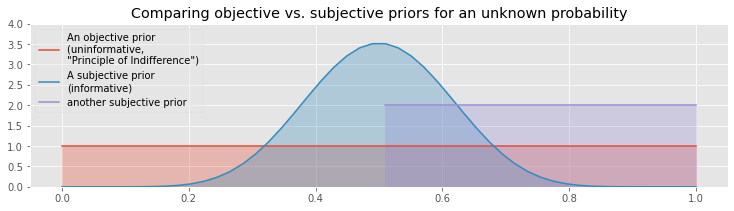

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

主观先验的选择并不总是意味着我们正在使用从业者的主观意见：更常见的情况是，主观先验曾经是先前问题的后验，现在从业者正在利用新数据更新这个后验。主观先验还可以用来将问题的*领域知识*注入模型中。我们稍后将看到这两种情况的例子。

决定，抉择...

选择，无论是*客观*还是*主观*，大多取决于所解决的问题，但也有一些情况下更偏好其中一种。在科学研究的情况下，选择客观先验是显而易见的。这可以消除结果中的任何偏见，两位可能持有不同先验观点的研究人员也会认为客观先验是公平的。考虑一个更极端的情况：

> 一个烟草公司发布了一份关于香烟使用的医学研究回顾报告，采用了贝叶斯方法论。你会相信这些结果吗？不太可能。研究人员可能选择了一个过于偏向有利于他们的主观先验。

不幸的是，选择客观先验并不像选择一个均匀先验那样简单，甚至今天这个问题仍未完全解决。简单地选择均匀先验的问题是可能会出现很多病态的情况。其中一些问题可能有些细微，但更严重的问题我们将推迟到本章的附录中。

我们必须记住，选择先验，无论是主观的还是客观的，仍然是建模过程的一部分。引用Gelman [5]的话：

“... 在模型拟合之后，应该查看后验分布，看看它是否合理。如果后验分布看起来不合理，这意味着有额外的先验知识可用，但尚未包含在模型中，这就与已经使用的先验分布的假设相矛盾。此时，应该回过头来改变先验分布，使其更符合这些外部知识。”

如果后验结果看起来不合理，那么很明显一个人已经有一个关于后验结果“应该”看起来如何的想法（而不是希望它看起来像什么），这意味着当前的先验并不包含所有的先验信息，应该进行更新。在这一点上，我们可以放弃当前的先验，选择更符合实际的先验。

Gelman [4]建议使用均匀分布并设定较大的边界作为客观先验的好选择。尽管如此，使用带有较大边界的均匀客观先验要谨慎，因为它可能会将太大的先验概率分配给不直观的点。问问自己：你真的认为未知量可能非常大吗？通常数量自然会偏向于0。具有大方差（小精度）的正态随机变量可能是一个更好的选择，或者在严格正（或负）的情况下，带有厚尾的指数分布可能更好。

如果使用特别主观的先验，那么你有责任能够解释选择该先验的原因，否则你就和烟草公司的有罪的人一样糟糕。

经验贝叶斯

虽然不是真正的贝叶斯方法，*经验贝叶斯*是一种结合频率主义和贝叶斯推断的技巧。正如之前提到的，对于（几乎）每个推断问题，都有一个贝叶斯方法和一个频率主义方法。两者之间的显着区别在于，贝叶斯方法具有一个先验分布，其中包含超参数$\alpha$，而经验方法没有任何先验概念。经验贝叶斯通过使用频率主义方法来选择$\alpha$，然后在原始问题上继续使用贝叶斯方法。

以下是一个非常简单的例子：假设我们希望估计正态分布的参数$\mu$，其中$\sigma = 5$。由于$\mu$可以在整个实数线上变化，我们可以使用正态分布作为$\mu$的先验。如何选择先验的超参数，表示为（$\mu_p，\sigma_p^2$）？$\sigma_p^2$参数可以选择反映我们的不确定性。对于$\mu_p$，我们有两个选项：

1. 经验贝叶斯建议使用经验样本均值，这将使先验围绕观察到的经验均值进行居中：

$$ \mu_p = \frac{1}{N} \sum_{i=0}^N X_i $$

2. 传统的贝叶斯推断建议使用先验知识，或者更客观的先验（零均值和较大的标准差）。

可以说经验贝叶斯是半客观的，因为虽然先验模型的选择是我们的（因此主观的），但参数完全由数据确定。

就个人而言，我觉得经验贝叶斯在*重复计数*数据。也就是说，我们使用数据两次：一次在先验中，在推断引擎MCMC中的观察数据会影响我们的结果，再一次在观察数据中。这种重复计数会低估我们真正的不确定性。为了最大程度地减少这种重复计数，我建议仅在有*大量*观测数据时使用经验贝叶斯，否则先验将产生过大的影响。如果可能的话，我还建议保持高不确定性（通过设置较大的$\sigma_p^2$或等效方式）。

经验贝叶斯也违反了贝叶斯推断的一个理论公理。贝叶斯推断的标准算法是：

>*先验* $\Rightarrow$ *观察到的数据* $\Rightarrow$ *后验*

而经验贝叶斯则违反了这一点，它使用了

>*观察到的数据* $\Rightarrow$ *先验* $\Rightarrow$ *观察到的数据* $\Rightarrow$ *后验*

理想情况下，所有先验都应该在我们观察数据之前指定，这样数据就不会影响我们的先验观点（请参阅丹尼尔·卡尼曼等人关于[锚定](http://en.wikipedia.org/wiki/Anchoring_and_adjustment)的大量研究）。

## 有关有用的先验信息

### 伽玛分布

伽玛随机变量，表示为 $X \sim \text{Gamma}(\alpha, \beta)$，是一个在正实数范围上的随机变量。实际上它是指数随机变量的一种泛化形式，即：

$$ \text{Exp}(\beta) \sim \text{Gamma}(1, \beta) $$

这个额外的参数使得概率密度函数具有更多的灵活性，因此允许从业者更准确地表达他们的主观先验。一个 $\text{Gamma}(\alpha, \beta)$ 随机变量的密度函数为：

$$ f(x \mid \alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)} $$

其中 $\Gamma(\alpha)$ 是[伽玛函数](http://zh.wikipedia.org/wiki/伽玛函数)，而对于不同的 $(\alpha, \beta)$ 值，它的样子如下：

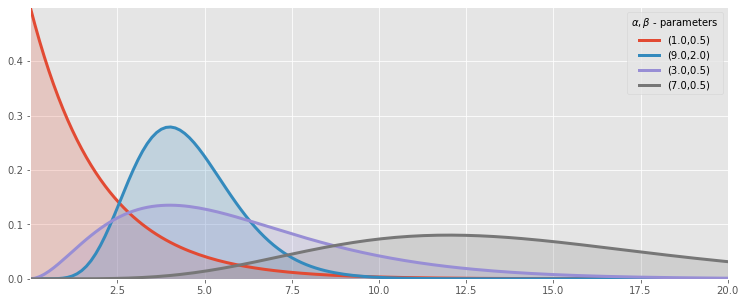

In [2]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001 ,20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(alpha,beta), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters");

### Wishart分布

到目前为止，我们只看到过标量的随机变量。当然，我们也可以有*随机矩阵*！具体来说，Wishart分布是一个分布，涵盖了所有[正半定矩阵](http://en.wikipedia.org/wiki/Positive-definite_matrix)。为什么在我们的工具库中拥有这个是有用的？(正确的) 协方差矩阵是正定的，因此Wishart是协方差矩阵的适当先验。我们实际上不能可视化矩阵的分布，所以我会绘制一些从$5 \times 5$ (上面) 和$20 \times 20$ (下面) Wishart分布中生成的实例。

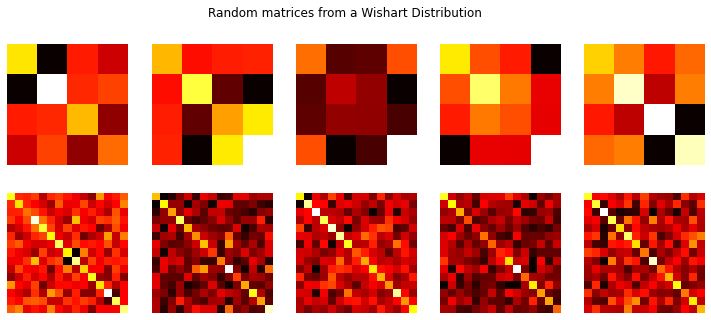

In [3]:

n = 4
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    if i >= 5:
        n = 15
    plt.imshow(stats.wishart.rvs(n+1, np.eye(n)), interpolation="none", 
                cmap = "hot")
    ax.axis("off")
    
plt.suptitle("Random matrices from a Wishart Distribution");

需要注意的一件事是这些矩阵的对称性。Wishart分布可能有些难以处理，但之后我们会在一个例子中使用它。

### Beta分布

您可能在本书中先前的代码中看到过术语 `beta` 。经常情况下，我正在实现一个Beta分布。Beta分布在贝叶斯统计中非常有用。如果随机变量 $X$ 服从一个 $(\alpha, \beta)$ 参数的 $\text{Beta}$ 分布，那么其密度函数为:

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

其中 $B$ 是 [Beta函数](http://en.wikipedia.org/wiki/Beta_function) （因此得名）。随机变量 $X$ 的取值范围仅限于 [0,1]，使得Beta分布成为十进制值、概率和比例的常见分布。参数 $\alpha$ 和 $\beta$ 均为正值，提供了巨大的灵活性以塑造分布的形状。下面我们绘制了一些分布图:

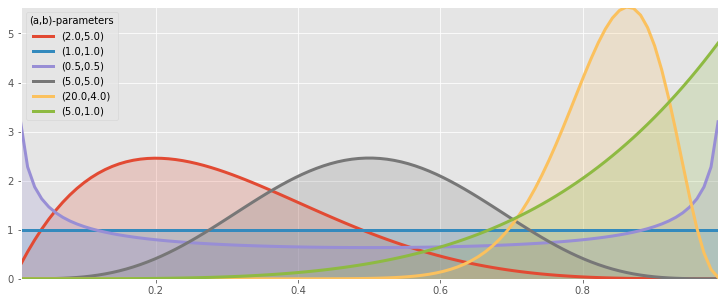

In [4]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc = 'upper left', title="(a,b)-parameters");

我希望读者注意的一件事是上面平坦分布的存在，由参数$(1,1)$指定。这是均匀分布。因此，Beta分布是均匀分布的泛化，我们将多次重新讨论这个问题。

Beta分布与二项分布之间有一个有趣的联系。假设我们对某个未知比例或概率$p$感兴趣。我们为$p$分配一个$\text{Beta}(\alpha, \beta)$先验。我们观察到通过二项过程生成的一些数据，比如$X \sim \text{Binomial}(N, p)$，其中$p$仍然未知。那么我们的后验*再次是一个Beta分布*，即$p | X \sim \text{Beta}( \alpha + X, \beta + N -X )。简而言之，可以通过“Beta先验与二项观察创建Beta后验”来将两者联系起来。这是一个非常有用的性质，无论是计算上还是启发上。

根据以上两段，如果我们从$p$的$\text{Beta}(1,1)$先验（即均匀分布）开始，观察数据$X \sim \text{Binomial}(N, p)$，那么我们的后验将是$\text{Beta}(1 + X, 1 + N - X)。

贝叶斯多臂老虎机

*改编自MapR Technologies的Ted Dunning的例子*

假设你面对$N$个老虎机（被形象地称为多臂老虎机）。每个老虎机有一个未知的分配奖品的概率（暂且假设所有老虎机的奖品相同，只是概率不同）。有些老虎机非常慷慨，而其他一些则不太慷慨。当然，你不知道这些概率是多少。每轮只能选择一个老虎机，我们的任务是设计一种策略来最大化我们的赢利。

当然，如果我们知道概率最大的老虎机，那么总是选择这个老虎机将产生最大的赢利。因此，我们的任务可以表述为“找到最好的老虎机，并尽快找到它”。

老虎机的随机性质让任务变得复杂。一个次优的老虎机纯粹因为偶然的原因可能会带来许多赢利，这会让我们相信它是一个非常有利可图的老虎机。同样地，最好的老虎机可能会带来很多空手而归的次数。我们应该继续尝试失败的老虎机呢，还是放弃呢？

一个更加棘手的问题是，如果我们找到一个结果“相当不赖”的老虎机，我们是否应该继续从中抽取以维持我们的“相当不赖的分数”，还是尝试其他老虎机，希望找到一个“更好”的老虎机？这是勘探与开发的困境。

### 应用

乍看之下，多臂老虎机问题似乎非常人为，只有数学家才会喜欢，但在我们解决一些应用问题之前，这只是因为我们没有考虑到一些应用：

- 互联网展示广告：公司有一套可以向访问者展示的潜在广告，但公司不确定应该遵循哪种广告策略来最大化销售。这类似于A/B测试，但具有自然地最小化不起作用策略的优势（并推广到A/B/C/D...策略）
- 生态学：动物有限定的能量要耗费，并且遵循某些行为有不确定的回报。动物如何最大化它的适应性？
- 金融：在变化的回报配置下，哪种股票期权提供了最高的回报。
- 临床试验：一名研究者希望在尽可能减少损失的情况下找到最佳治疗方法，这包括许多可能的治疗方案。
- 心理学：惩罚和奖励如何影响我们的行为？人类如何学习？

以上许多问题对于各自领域的应用都具有基本性质。

事实证明，*最优解*非常困难，几十年才发展出一个全面的解决方案。还有许多近似最优解，这些近似解非常好。我想讨论的一个解决方案是少数几个可以获得极大规模的解决方案之一。这个解决方案被称为*贝叶斯老虎机*。

In [5]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

下面我们展示贝叶斯赌博解决方案的学习过程。

In [6]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

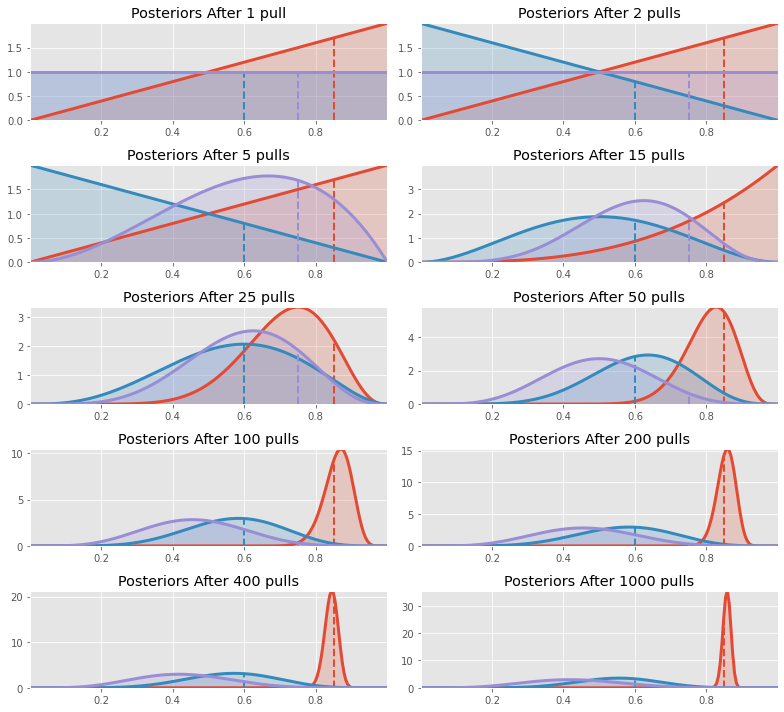

In [7]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

请注意，我们并不特别关心我们对隐藏概率的推断变得多么准确 - 对于这个问题，我们更感兴趣的是选择最佳的赌徒（或更准确地说，变得*更有信心*选择最佳的赌徒）。因此，红色赌徒的分布非常宽（代表对隐藏概率可能是多少的无知），但我们相当有信心它不是最佳选择，所以算法选择忽略它。

根据以上内容，我们可以看到在1000次拉动后，“蓝色”功能的大部分领先，因此我们几乎总是会选择这支臂。这是好事，因为这支臂确实是最佳选择。

下面是一个演示我们算法更新/学习三个赌徒的D3应用程序。第一幅图是拉动和赢得的原始计数，第二幅图是一个动态更新的图表。我鼓励您在揭示真实概率之前，通过选择`臂按钮`来猜测哪个赌徒是最佳选择。

In [8]:
from IPython.core.display import HTML

#try executing the below command twice if the first time doesn't work
HTML(filename = "BanditsD3.html")

观察到的比率与最大概率之间的偏差是性能的衡量标准。例如，在长期内，最优地，我们可以达到最大赌徒概率的奖励/拉动比例。长期实现的比率小于最大值表示低效率。（实现的比率大于最大概率是由于随机性，最终会降至以下）。

### 一个*好*的衡量标准

我们需要一个指标来计算我们的表现如何。请记住，我们能做到的绝对*最好*的是始终选择具有最高获胜概率的赌徒。用$w_{opt}$表示这个最佳赌徒的概率。我们的得分应该相对于如果我们从一开始就选择了最佳赌徒，我们将取得的结果而言。这就引出了一种策略的*总后悔*，定义如下：

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}

其中$w_{B(i)}$是第$i$轮选择的赌徒的奖励概率。总后悔为0意味着该策略与最佳可能得分相匹配。这很可能不太可能实现，因为最初我们的算法经常会作出错误的选择。理想情况下，随着策略学习最佳赌徒，其总后悔应该逐渐平稳。（数学上，我们经常实现$w_{B(i)}=w_{opt}$）

下面我们绘制这个模拟的总后悔，包括一些其他策略的分数：

1. 随机：随机选择一个赌徒。如果你无法打败这个策略，就停止。
2. 最大贝叶斯可信区间：选择其95%可信区间下限最大的赌徒。
3. 贝叶斯UCB算法：选择具有最大*分数*的赌徒，其中分数是后验的动态分位数。
4. 后验均值：选择后验概率均值最大的赌徒。这是一个没有计算机的人类玩家可能会做的事情。
5. 最大比例：选择当前观察到的获胜比例最大的赌徒。

这些策略的代码在`other_strats.py`中，您可以很容易地实现自己的策略。

In [9]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

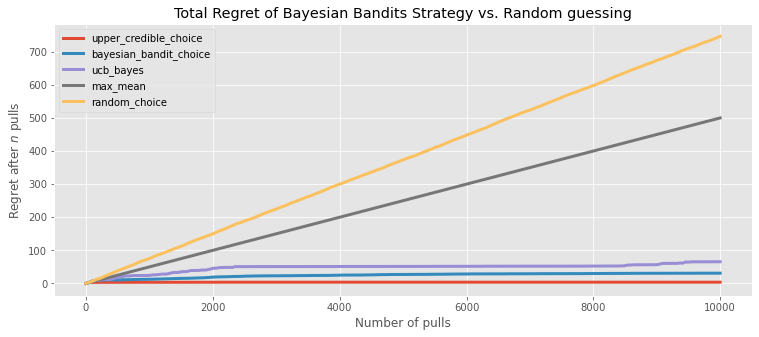

In [10]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

就像我们希望的那样，贝叶斯赌徒和其他策略的遗憾率在减少，表示我们正在实现最佳选择。为了更加科学，以便在上述模拟中消除任何可能的运气，我们应该看*期望总遗憾*：

$$\bar{R}_T = E[ R_T ] $$

可以证明，任何*次优*策略的期望总遗憾在对数下方是有界的。形式上，

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

因此，任何与对数增长遗憾相匹配的策略被称为“解决”多臂赌徒问题[3]。

利用大数定律，我们可以通过多次进行相同实验（500次，公平地）来近似贝叶斯赌徒的期望总遗憾：

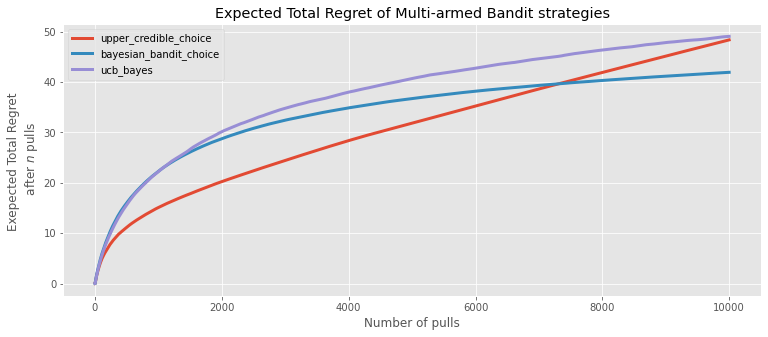

In [11]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

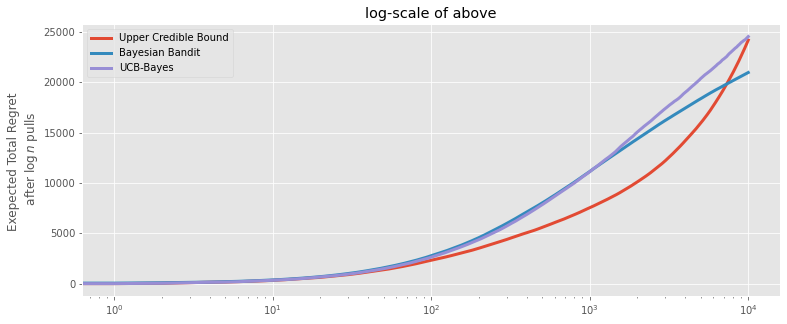

In [12]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

### 扩展算法

由于Bayesian Bandits算法的简单性，扩展起来很容易。一些可能性：

- 如果对*最小*概率感兴趣（例如：当奖品是一件坏事时），只需要选择 $B = \text{argmin} \; X_b$ 然后继续。

- 添加学习率：假设基础环境可能随时间改变。从技术上讲，标准的Bayesian Bandit算法将通过自我更新（很棒）注意到它认为最好的东西开始更频繁地失败。我们可以通过在更新时简单地添加一个*速率*项来激励算法更快地学习变化的环境：

        self.wins[choice] = rate*self.wins[choice] + result
        self.trials[choice] = rate*self.trials[choice] + 1

   如果`rate < 1`，算法将更快地*忘记*其以前的胜利，向无知的方向压力更大。相反，设定`rate > 1`意味着你的算法将更有风险，更经常押注于早期的获胜者，并更抵御环境的变化。

- 分层算法: 我们可以在较小的bandit算法之上设置一个Bayesian Bandit算法。假设我们有$N$个Bayesian Bandit模型，每个模型在某些行为上有所不同（例如不同的`rate`参数，表示对环境变化的敏感程度不同）。在这$N$个模型之上是另一个Bayesian Bandit学习者，它将选择一个子Bayesian Bandit。然后，选择的Bayesian Bandit将根据哪个机器选择在内部做出选择。超级Bayesian Bandit会根据子Bayesian Bandit的正确与否更新自身。

- 将奖励扩展到随机变量$y_a$，代表bandit $a$，从分布 $f_{y_a}(y)$是很直接的。更一般地说，这个问题可以重新表述为“找到预期值最大的bandit”，因为玩预期值最大的bandit是最佳的。在上面的例子中，$f_{y_a}$是伯努利，概率为$p_a$，因此bandit的期望值等于$p_a$，这就是为什么看起来我们的目标是最大化获取奖品的概率。如果$f$不是伯努利，且是非负的，这可以通过移动分布（我们假设我们知道$f$）事先实现，那么算法会像以前一样表现: 

   对于每一轮，
    
   1. 为所有的$b$，从bandit $b$的先验中样本一个随机变量$X_b$。
   2. 选择具有最大样本的bandit，即选择$B = \text{argmax}\;\; X_b$。
   3. 观察拉动bandit $B$的结果$R \sim f_{y_a}$，并更新对bandit $B$的先验。
   4. 返回到1

   问题在于采样$X_b$的绘制阶段。对于贝塔先验和伯努利观察，我们有一个贝塔后验，这很容易从中抽样。但现在，用任意分布$f$，我们有一个复杂的后验。从这些中抽样可能是困难的。

- 人们对将贝叶斯Bandit算法扩展到评论系统表现出了一定的兴趣。回顾第四章，我们基于比例的贝叶斯下限开发了一个排名算法。这种方法的问题之一是，它会使顶级排名偏向更老的评论，因为更老的评论自然会有更多的投票（因此下限更接近真实比例）。这就创造了一个正反馈循环，老评论获得更多投票，因此更频繁地显示，因此获得更多投票，以此类推。这将任何可能更好的新评论推到底部。J. Neufeld提出了一种解决这个问题的系统，使用贝叶斯Bandit解决方案。

他的提议是将每条评论都视为一个Bandit，抽取次数等于投票数，奖励次数等于点赞数，因此形成一个$\text{Beta}(1+U,1+D)$后验。当访问者访问页面时，从每个Bandit/评论中绘制样本，但不是显示具有$\max$样本的评论，而是根据它们各自样本的排名对评论进行排名。从J. Neufeld的博文中[7]：

   > [The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments.

尽管颜色爆炸，我们只是为了好玩而观看贝叶斯强盗算法学习15种不同的选择。

[0.01316003 0.0470422  0.10278464 0.02769084 0.0282016  0.02893928
 0.13485387 0.02336669 0.02246445 0.03354184 0.05025746 0.12199161
 0.01499722 0.01608101 0.12336017 0.03335515 0.0600726  0.05795924
 0.0643701  0.03606559 0.09241004 0.05762127 0.15399929 0.02956034
 0.10352865 0.25244598 0.01693866 0.00323096 0.06597221 0.00389394
 0.13672946 0.17195421 0.06365645 0.06637099 0.01518599]


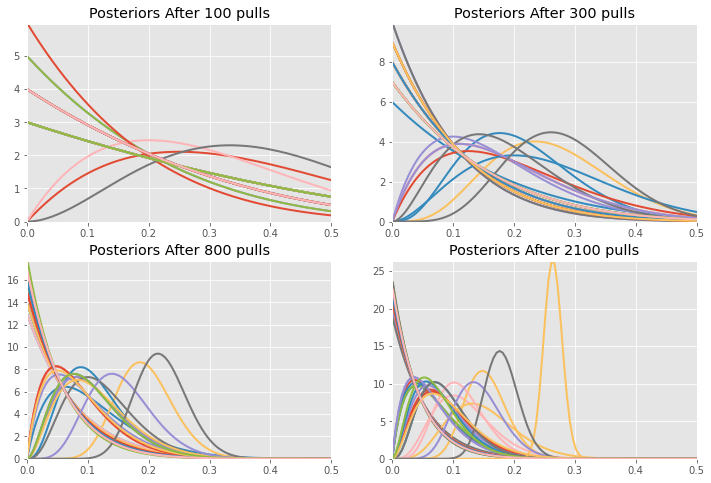

In [13]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)


## 征求专家先验信息

指定一个主观先验是实践者将有关问题的领域知识纳入数学框架的方式。允许领域知识有许多好处：

- 有助于MCMC收敛速度。例如，如果我们知道未知参数严格为正，那么我们可以限制注意力在那里，从而节省在探索负值时可能会花费的时间。
- 更准确的推断。通过使接近真实未知值的先验值权重更高，我们正在缩小最终的推断范围（使后验紧密地围绕未知值）。
- 更好地表达我们的不确定性。请参阅第5章中的*Price is Right*问题。

还有很多其他原因。当然，贝叶斯方法的实践者并不是每个领域的专家，因此我们必须求助于领域专家来设计我们的先验。不过，我们必须谨慎地引导这些先验。以下是一些需要考虑的事项：

1. 根据经验，我会避免向非贝叶斯实践者介绍贝塔分布、伽玛分布等。此外，非统计学家可能会困惑于连续概率函数如何会有一个超过1的值。

2. 个人经常忽视罕见的*尾事件*，并在分布的平均值周围放置过多的权重。

3. 与上述相关的是，几乎总是个人会低估其猜测中的不确定性。

从非技术专家那里引导先验尤其困难。与其向专家介绍可能会使其害怕的概率分布、先验等概念，有一种更简单的解决方案。

### 试验式轮盘方法

*试验式轮盘法* [8] 重点是通过将计数器（类似于赌场筹码）放置在专家认为可能发生的结果上来构建一个先验分布。专家会得到$N$个计数器（比如$N=20$），并被要求将它们放置在一个预先印制的网格上，网格的盒子代表间隔。每一列将代表他们对对应盒子的结果概率的信任。每个筹码将代表概率增加 $\frac{1}{N} = 0.05$ 以使结果在该间隔的概率增加。例如 [9]：

> 一个学生被要求预测未来考试的分数。下图显示了用于引导主观概率分布的网格。网格的横轴显示了学生被要求考虑的可能箱子（或分数间隔）。顶部行中的数字记录了每个箱子中筹码的数量。完成的网格（使用总共20个筹码）显示该学生相信考试分数将在60到64.9之间的概率为30%。

从中，我们可以拟合一个捕捉专家选择的分布。使用这种技术的一些优点包括：

1. 可以回答关于专家主观概率分布形状的许多问题，不需要向专家提出一系列长问题 - 统计学家可以简单地读出任意给定点上方或下方的密度，或者两个点之间的密度。

2. 在引导过程中，如果专家对他们最初放置的位置不满意，他们可以移动筹码 - 因此他们可以确保最终结果是准确的。

3. 它迫使专家在提供的概率集合中保持一致。如果所有筹码都被使用，那么概率必须总和为1。

4. 图形方法似乎提供更准确的结果，特别是对统计水平适度的参与者。

##### 示例：股票回报

注意股票经纪人：你做错了。在选择要投资的股票时，分析师经常会查看股票的*每日回报*。假设$S_t$是第$t$天的股票价格，则第$t$天的每日回报为：

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

股票的*预期每日回报*用$\mu = E[ r_t ]$表示。显然，具有高预期回报的股票是令人向往的。不幸的是，股票回报中充斥着大量噪音，很难估计这个参数。此外，该参数可能随时间改变（考虑苹果公司股票的涨跌），因此使用大量历史数据集是不明智的。

从历史上看，预期回报是通过使用样本均值来估计的。这是一个不好的主意。如前所述，小样本数据集的样本均值有着非常大的潜力出现非常错误的情况（详见第4章了解更多细节）。因此，贝叶斯推断是正确的程序，因为我们能够看到我们的不确定性以及可能的值。

在这个练习中，我们将研究苹果公司（AAPL）、谷歌（GOOG）、微软（MSFT）和亚马逊（AMZN）的每日回报。在我们提取数据之前，假设我们向我们的股票基金经理（一位金融专家，但参见[10]）提出以下问题：

> 你认为这些公司的回报轮廓是怎样的？

我们的股票经纪人不需要了解正态分布、先验、方差等语言，就以上述试验方法创建了四个分布。假设它们足够像正态分布，因此我们将它们拟合成正态分布。它们可能看起来像：

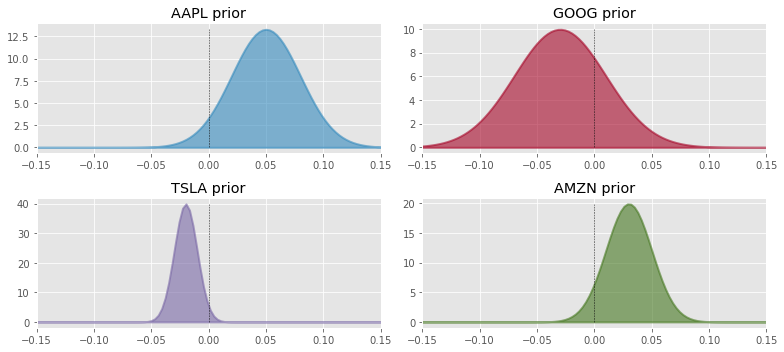

In [14]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04), 
                 "TSLA": (-0.02, 0.01), 
                 "AMZN": (0.03, 0.02), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

请注意，这些是主观先验：专家对这些公司的股票回报有个人看法，并且用分布来表达。他并不是一厢情愿的思考，而是引入领域知识。

为了更好地建模这些回报，我们应该调查回报的*协方差矩阵*。例如，投资于两只高度相关的股票是不明智的，因为它们很可能会一起下跌（这也是为什么基金经理建议分散投资策略）。我们将使用之前介绍的*Wishart分布*来完成这个工作。

让我们获取这些股票的一些历史数据。我们将使用股票收益的协方差作为我们 Wishart 随机变量的起点。这并不是经验贝叶斯（因为我们稍后会讨论）因为我们只是决定起始点，而不是影响参数。

In [16]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
import datetime
import collections
#import ystockquote as ysq
import pandas as pd
import pandas_datareader as pdr

n_observations = 100 # we will truncate the the most recent 100 days.

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    data = pdr.get_data_yahoo(stock,start=startdate,end=enddate)["Close"]
    #x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    #stock_series = pd.Series(x[1:,CLOSE].astype(float), name=stock)
    stock_closes[stock] = data

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]
    
#dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations+1,0]))
dates = stock_returns.index.to_list()

这里让我们构建我们的基本模型：

In [17]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.tensor.nlinalg import matrix_inverse, matrix_dot
from pytensor.tensor.basic import diag
prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, initval = init)

    mu = pm.Normal("returns", mu=prior_mu, sigma=1, shape=4)

Added new variable covariance_c to model diagonal of Wishart.
Added new variable covariance_z to model off-diagonals of Wishart.


这是我们选择的股票的回报：

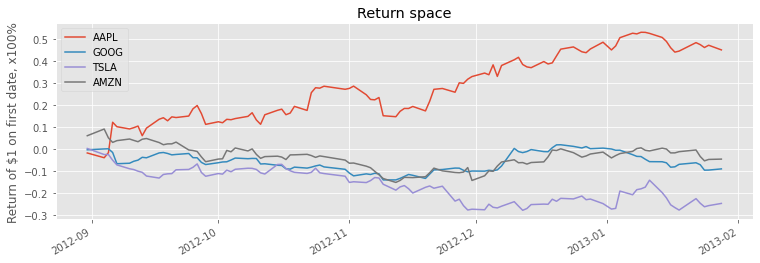

In [18]:
figsize(12.5, 4)

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates[::-1]
cum_returns.plot()

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

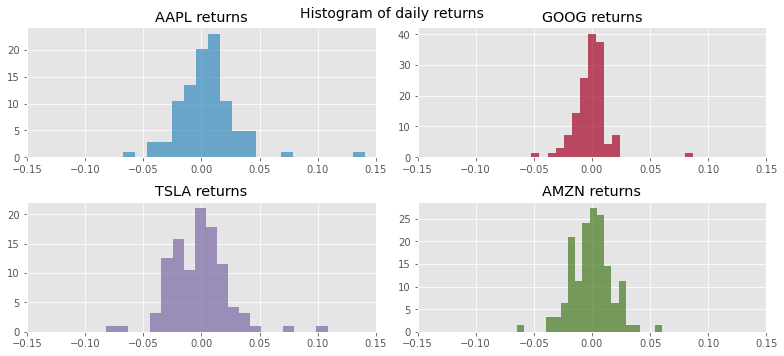

In [19]:
figsize(11., 5 )

for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             density = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size =14);

在下面，我们对后验平均收益和后验协方差矩阵进行推断。

In [20]:
with model:
    obs = pm.MvNormal("observed returns", mu=mu, cov=cov_matrix, observed=stock_returns)
    # step = pm.NUTS()
    # We use chains=1 for quicker progress
    trace = pm.sample(5000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [covariance_c, covariance_z, returns]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 26 seconds.


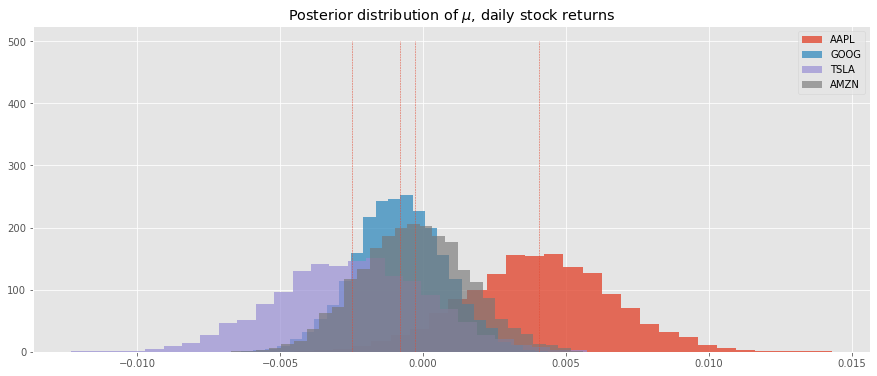

In [21]:
figsize(15,6)

#examine the mean return first.
mu_samples = trace.posterior.returns.data[0]

for i in range(4):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

像这样的情节是启发了这本书的封面的灵感。

关于上面的结果我们可以说什么呢？很明显 TSLA 是一个表现强劲的股票，我们的分析表明它几乎每日回报接近1%！同样，AAPL 的大部分分布是负面的，这表明它的*真实每日回报*是负面的。

你可能没有立即注意到，但这些变量比我们对它们的先验值低一个数量级。例如，将这些放在与上面的先验分布相同的尺度上：

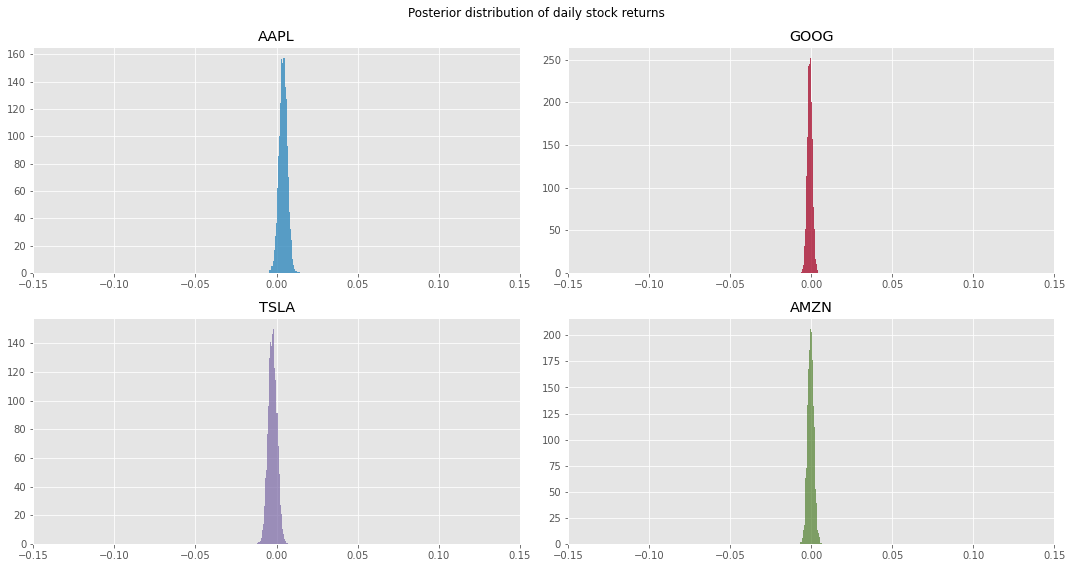

In [22]:
figsize(15.0,8)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

为什么会发生这种情况？回想一下我提到过财务领域的信号噪声比非常低。这意味着一个更加困难进行推理的环境。我们应该小心地解读这些结果：请注意（在第一张图中），每个分布在0处都是正的，这意味着股票可能不会有任何回报。此外，主观先验会影响结果。从基金经理的角度来看，这是好事，因为这反映了他对股票的更新信念，然而从中立的角度来看，这可能会过于主观。

下面我们展示后验相关矩阵和后验标准差。需要注意的是，Wishart分布对应的是*逆协方差矩阵*，所以我们必须对其进行反转以得到协方差矩阵。我们还对矩阵进行标准化以获得*相关矩阵*。由于无法有效地绘制数百个矩阵，我们通过总结后验相关矩阵的分布，展示*平均后验相关矩阵*（定义在第2行）。

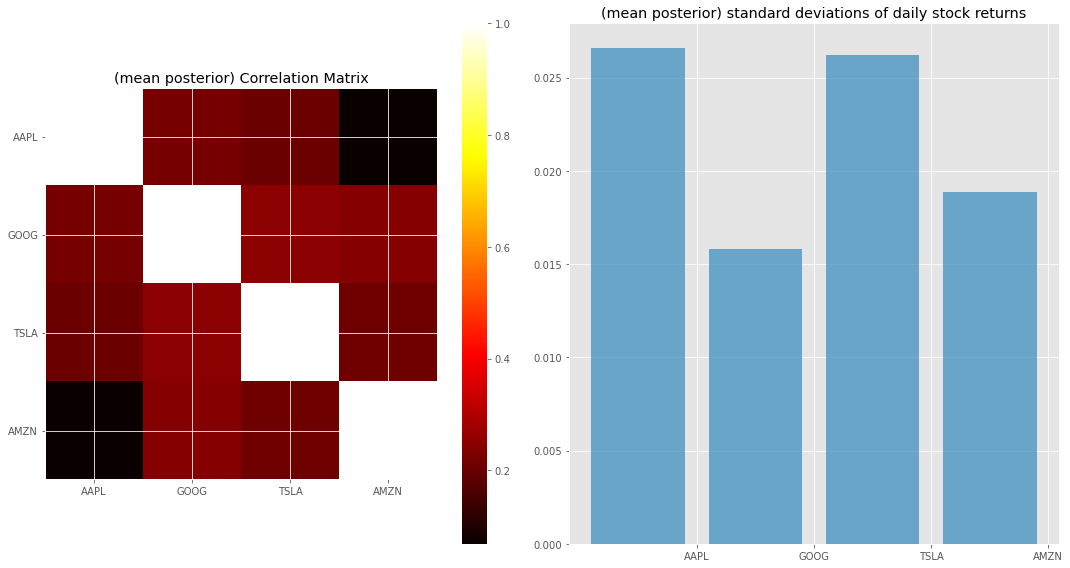

In [23]:
cov_samples = trace.posterior.covariance.data[0]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "hot") 
plt.xticks(np.arange(4), stock_returns.columns)
plt.yticks(np.arange(4), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color = "#348ABD", alpha = 0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.columns);
plt.title("(mean posterior) standard deviations of daily stock returns")

plt.tight_layout();


从上述数据看，我们可以说TSLA可能具有高于平均水平的波动性（从回报图来看，这一点很明显）。相关性矩阵显示，没有强相关性存在，但也许GOOG和AMZN之间表现出较高的相关性（约为0.30）。

通过这种对股市的贝叶斯分析，我们可以将其投入平均-方差优化器（我必须再次强调，不要与频率学派点估计一起使用）并找到最小值。该优化器在高回报和高方差之间平衡权衡。

其中 $$ w_{opt} = \max_{w} \frac{1}{N}\left( \sum_{i=0}^N \mu_i^T w - \frac{\lambda}{2}w^T\Sigma_i w \right) $$

其中$\mu_i$和$\Sigma_i$是第$i$个后验均值估计和协方差矩阵。这是另一个损失函数优化的示例。

### Wishart 分布的专业提示

如果您计划使用Wishart分布，请继续阅读。否则，随意跳过。

在上面的问题中，Wishart分布的表现相当好。不幸的是，这种情况很少发生。问题在于，估计一个$NxN$协方差矩阵涉及估计$\frac{1}{2}N(N-1)$个未知数。即使对于适度的$N$，这也是一个很大的数字。个人而言，我尝试过使用$N=23$支股票执行类似于上面的模拟，最终考虑到要求我的MCMC模拟至少估计$\frac{1}{2}23*22=253$个额外未知数（加上问题中其他有趣的未知数）。这对于MCMC来说并不容易。基本上，您要求MCMC在250+维空间中穿行。而这个问题似乎起初看起来是那么无害！以下是一些提示，按照重要性顺序排列：

1. 如适用，请使用共轭性。参见下面的部分。

2. 使用好的起始值。什么样的起始值可能是好的？那就是数据的样本协方差矩阵！请注意，这不是经验贝叶斯：我们没有触及先验参数，我们是修改MCMC的起始值。由于数值不稳定性，最好将样本协方差矩阵中的小数截断到几个精度级别（例如，不稳定性可能导致矩阵不对称，这可能导致PyMC3出现问题）。

3. 在可能的情况下，尽可能提供领域知识的先验形式。我强调 * 在可能的情况下*。可能不可能对每个$\frac{1}{2}N(N-1)$个未知数的估计都有一个评估。在这种情况下，请参见第4点。

4. 使用经验贝叶斯，即使用样本协方差矩阵作为先验参数。

5. 对于$N$非常大的问题，任何事情都不会有帮助。相反，问问自己，我真的关心*每个*相关性吗？可能不。进一步问问自己，我真的很在意相关性吗？可能也不是。在金融领域，我们可以设置我们可能最感兴趣的事情的非正式等级制度：首先是$\mu$的良好估计，其次是协方差矩阵对角线上的方差，最后是相关性最不重要。因此，最好忽略$\frac{1}{2}(N-1)(N-2)$个相关性，而是专注于更重要的未知数。

**另一件事**要注意的是，Wishart分布的实现已经从PyMC更改为PyMC3。Wishart分布矩阵必须具有一些非常限制性的数学特征。这使得MCMC方法无法提出在我们的抽样过程中将被接受的矩阵。在我们的模型中，我们对Wishart分布矩阵的Bartlett分解进行抽样，然后使用它来计算我们的协方差矩阵的样本（http://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition）。

共轭先验

回想一下，具有二项分布数据的贝塔先验意味着贝塔后验。图形上:

$$ \underbrace{\text{Beta}}_{\text{prior}} \cdot \overbrace{\text{Binomial}}^{\text{data}} = \overbrace{\text{Beta}}^{\text{posterior} } $$

请注意此方程两侧的贝塔（不，您不能取消它们，这不是一个 *真正* 的方程）。这是一个非常有用的属性。它使我们可以避免使用MCMC，因为后验可以用封闭形式表示出来。因此推断和分析很容易推导。这个快捷方式是上面的贝叶斯老虎机算法的核心。幸运的是，存在一个具有类似行为的整个分布家族。

假设 $X$ 来自一个已知分布，或者被认为来自一个已知分布，称为 $f_{\alpha}$，其中 $\alpha$ 是 $f$ 的可能未知参数。$f$ 可能是正态分布，或者二项分布等等。对于特定的分布 $f_{\alpha}$，可能存在一个先验分布 $p_{\beta}$，使得:

$$ \overbrace{p_{\beta}}^{\text{prior}} \cdot \overbrace{f_{\alpha}(X)}^{\text{data}} = \overbrace{p_{\beta'}}^{\text{posterior} } $$

其中 $\beta'$ 是不同的参数集合 *但 $p$ 与先验相同的分布*。满足此关系的先验 $p$ 被称为*共轭先验*。正如我之前提到的，它们在计算上很有用，因为我们可以避免使用MCMC进行近似推断，直接得到后验。听起来很不错，对吧？

不幸的是，情况并非如此。共轭先验存在一些问题。

1. 共轭先验不是客观的。因此只在需要主观先验时有用。不能保证共轭先验可以包容从业者的主观观点。

2. 对于简单的一维问题通常存在共轭先验。对于涉及更复杂结构的更大问题，很难找到共轭先验。对于更小的模型，维基百科有一个不错的[共轭先验表格](http://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)。

实际上，共轭先验仅仅在数学上的便利性上有用：从先验到后验很简单。我个人认为共轭先验只是一个巧妙的数学技巧，并对问题本身提供很少见解。

## Jeffrey先验分布

之前，我们谈到客观先验分布很少是“客观”的。部分原因是我们希望一个先验分布不会对后验估计产生偏见。平坦先验分布似乎是一个合理的选择，因为它将所有值赋予相等的概率。

但是，平坦先验分布并不是变换不变的。这意味着什么？假设我们有一个来自伯努利分布($\theta$)的随机变量$\textbf X$。我们将先验定义为$p(\theta) = 1$。

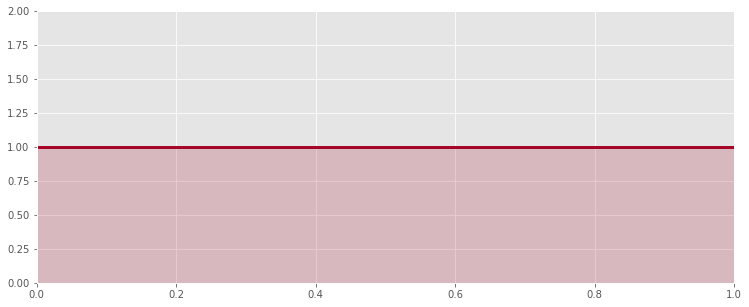

In [24]:
figsize(12.5, 5)

x = np.linspace(0.000 ,1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw = 3)
plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 2);

现在，让我们用函数$\psi = log \frac{\theta}{1-\theta}$来转换$\theta$。这只是一个将$\theta$延伸到实线上的函数。现在在我们的转换下，不同$\psi$值的可能性有多大呢？

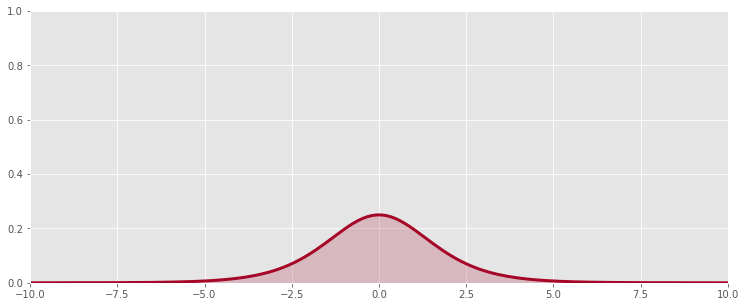

In [25]:
figsize(12.5, 5)

psi = np.linspace(-10 ,10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 1);

哎呀！我们的函数不再是平的了。原来平的先验确实包含了信息。Jeffreys Prior的目的是创建先验，使其在对其进行变换时不会意外地变得具有信息性。

Jeffreys Prior被定义为：

$$p_J(\theta) \propto \mathbf{I}(\theta)^\frac{1}{2}$$
$$\mathbf{I}(\theta) = - \mathbb{E}\bigg[\frac{d^2 \text{ log } p(X|\theta)}{d\theta^2}\bigg]$$

其中，$\mathbf{I}$ 是*Fisher信息*。

随着 $N$ 的增加，先验的影响

在第一章中，我提出随着我们的观察或数据量增加，先验的影响会减少。这是直观的。毕竟，我们的先验是基于先前信息的，最终足够多的新信息将使我们先前信息的价值变得微不足道。足够数据消减先验也是有帮助的：如果我们的先验显著错误，那么数据的自我纠正性质将呈现给我们一个*更少错误*，最终*正确*的后验。

我们可以从数学角度看到这一点。首先，回顾一下第一章的贝叶斯定理，它将先验与后验联系起来。以下是来自[样本量与先验对后验产生影响的关系是什么？](http://stats.stackexchange.com/questions/30387/what-is-the-relationship-between-sample-size-and-the-influence-of-prior-on-poste)在CrossValidated上的示例。

> 参数 $\theta$ 的后验分布，给定数据集 ${\textbf X}$，可以写成

$$p(\theta | {\textbf X}) \propto \underbrace{p({\textbf X} | \theta)}_{{\textrm likelihood}}  \cdot  \overbrace{ p(\theta) }^{ {\textrm prior} }  $$



> 或者，通常在对数尺度上显示，

$$ \log( p(\theta | {\textbf X})  ) = c + L(\theta;{\textbf X}) + \log(p(\theta)) $$

> 对数似然函数，$L(\theta;{\textbf X}) = \log \left( p({\textbf X}|\theta) \right)$， **随着样本量的增加而增长**，因为它是数据的函数，而先验概率密度不是。因此，随着样本量的增加，$L(\theta;{\textbf X})$ 的绝对值变大，而 $\log(p(\theta))$ 保持不变（对于一个固定的 $\theta$ 值），因此总和 $L(\theta;{\textbf X}) + \log(p(\theta))$ 在样本量增加时更受 $L(\theta;{\textbf X})$ 的影响。

还有一个不太明显的有趣结果。随着样本量的增加，所选择的先验影响变小。因此，推断会收敛，而不管选择的先验是什么，只要非零概率的区域相同。

在下面我们将这个结果可视化。我们检验二项分布参数 $\theta$ 的两个后验的收敛性，一个与平坦先验，另一个与朝向0的有偏先验。随着样本量的增加，后验和因此推断收敛。

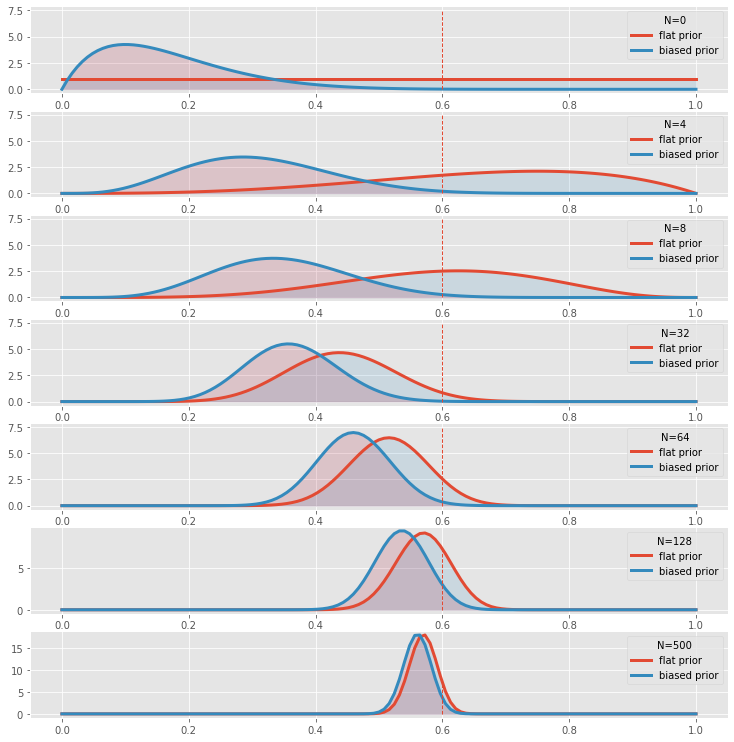

In [26]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = stats.bernoulli.rvs(p, size=500)

plt.figure()
for i,N in enumerate([0,4,8, 32,64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf( x, *params2)
    plt.plot(x,y1, label = r"flat prior", lw =3)
    plt.plot(x, y2, label = "biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between(x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#


请记住，并不是所有的后验都会这么快地“忘记”先验。这个例子只是为了表明*最终*先验会被遗忘。随着我们接触到越来越多的数据，先验被忘记的”遗忘性“正是贝叶斯派和频率派推理最终会收敛的原因。

### 贝叶斯观点下的惩罚线性回归

惩罚最小二乘回归和贝叶斯先验之间有一个非常有趣的关系。惩罚线性回归是一个形式为以下优化问题：

$$ \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta)  + f(\beta)$$

其中$f$是某个函数（通常是类似于$|| \cdot ||_p^p$的泛函）。

我们首先描述最小二乘线性回归的概率解释。将我们的响应变量$Y$，特征包含在数据矩阵$X$中。标准线性模型为：

\begin{equation}
Y = X\beta + \epsilon
\end{equation}

其中$\epsilon \sim \text{Normal}( {\textbf 0}, \sigma{\textbf I })$。简单来说，观测到的$Y$是$X$（具有系数$\beta$）的线性函数加上一些噪声项。我们要确定的未知量是$\beta$。我们利用正态随机变量的以下性质：

$$ \mu' + \text{Normal}( \mu, \sigma ) \sim \text{Normal}( \mu' + \mu , \sigma ) $$

将上述线性模型重写为：

\begin{align}
& Y = X\beta + \text{Normal}( {\textbf 0}, \sigma{\textbf I }) \\\\
& Y = \text{Normal}( X\beta , \sigma{\textbf I }) \\\\
\end{align}

在概率表示中，$f_Y(y \; | \; \beta )$表示$Y$的概率分布，并回顾正态随机变量的密度函数（参见[这里](http://en.wikipedia.org/wiki/Normal_distribution)）：

$$ f_Y( Y \; |\; \beta, X) = L(\beta|\; X,Y)= \frac{1}{\sqrt{ 2\pi\sigma} } \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) $$

这是$\beta$的似然函数。取对数：

$$ \ell(\beta) = K - c(Y - X\beta)^T(Y - X\beta) $$

其中$K$和$c>0$是常数。最大似然技术希望最大化$\beta$的值，

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; - (Y - X\beta)^T(Y - X\beta) $$

等效地，我们可以*最小化上述的负值*：

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) $$

这就是熟悉的最小二乘线性回归方程。因此，我们展示了线性最小二乘的解等同于假设正态噪声的最大似然。接下来我们将展示如何通过对$\beta$的先验进行适当选择来得到惩罚线性回归。

#### 惩罚最小二乘

在上述过程中，一旦有了似然函数，我们可以在$\beta$上包含一个先验分布，以推导后验分布的方程：

$$P( \beta | Y, X ) = L(\beta|\;X,Y)p( \beta )$$

其中$p(\beta)$是$\beta$元素的先验。一些有趣的先验是什么呢？

1\. 如果我们*没有明确的*先验项，实际上是包含了一个无信息的先验，$P( \beta ) \propto 1$，可以将其视为对所有数字均匀的先验。

2\. 如果我们有理由认为$\beta$的元素不会太大，我们可以假定 *先验*：

$$ \beta \sim \text{Normal}({\textbf 0 }, \lambda {\textbf I } ) $$

得到的$\beta$的后验密度函数*与*：

$$ \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) \exp \left( \frac{1}{2\lambda^2} \beta^T\beta \right) $$

成正比，对此取对数，并结合重新定义的常数，我们得到：

$$ \ell(\beta) \propto K -  (Y - X\beta)^T(Y - X\beta) - \alpha \beta^T\beta  $$

我们得到希望最大化的函数（回顾最大化后验分布的点是MAP，或*最大后验*)：

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; -(Y - X\beta)^T(Y - X\beta) - \alpha \;\beta^T\beta $$

等效地，我们可以最小化上述的负值，并重新编写$\beta^T \beta = ||\beta||_2^2$：

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_2^2$$

以上这项正是岭回归。因此我们可以看到岭回归对应于具有正态误差和正态先验$\beta$的线性模型的MAP。

3\. 类似地，如果我们假设*拉普拉斯*先验在$\beta$上，

$$ f_\beta( \beta) \propto \exp \left(- \lambda ||\beta||_1 \right)$$

并按照上述步骤进行，我们恢复得到：

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_1$$

这就是LASSO回归。关于这种等价性的一些重要说明。LASSO正则化导致稀疏性不是由于先验分配高概率给稀疏性。实际上恰恰相反。这是$|| \cdot ||_1$函数的组合与使用MAP一起在$\beta$上产生稀疏性的：[纯粹的几何论证](http://camdp.com/blogs/least-squares-regression-l1-penalty)。先验确实有助于将系数整体收缩至0。可以在[2]中找到有关此内容的有趣讨论。

关于贝叶斯线性回归的示例，请参见第4章有关金融损失的示例。

参考文献

1. Macro。“样本大小与先验对后验的影响之间的关系是什么？”2013年6月13日。StackOverflow，Cross-Validated在线发布。网络。2013年4月25日。

2. Starck, J.-L.等。“稀疏性和贝叶斯观点。”天文学与天体物理学。（2013）：n.页。印刷。

3. Kuleshov，Volodymyr和Doina Precup。“多臂赌博问题的算法。”机器学习研究杂志。（2000）：1-49。印刷。

4. Gelman, Andrew。“层次模型中方差参数的先验分布。”贝叶斯分析。1.3（2006）：515-533。印刷。

5. Gelman, Andrew和Cosma R. Shalizi。“贝叶斯统计的哲学与实践。”英国数学统计心理学杂志。（2012）：n.页。网络。2013年4月17日。

6. http://jmlr.csail.mit.edu/proceedings/papers/v22/kaufmann12/kaufmann12.pdf

7. James, Neufeld。“Reddit的“最佳”评论评分算法作为多臂赌博任务。”简单机器学习技巧。博主，2013年4月9日。网络。2013年4月25日。

8. Oakley, J.E.，Daneshkhah, A。和O’Hagan，A。使用轮盘方法进行非参数引导。提交给贝叶斯分析。

9. “从专家那里引导先验。”2010年7月19日。StackOverflow，Cross-Validated在线发布。网络。2013年5月1日。<http://stats.stackexchange.com/questions/1/eliciting-priors-from-experts>。

10. Taleb, Nassim Nicholas（2007），《黑天鹅：高度不可能事件的影响》，Random House，ISBN 978-1400063512

In [27]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()